Download and process an arbitrary file from Common Crawl, extract individual items, perform basic statistical analysis (distribution of hosts, words, etc.) and visualization (optional)

In [39]:
!aws s3 cp s3://commoncrawl/crawl-data/CC-NEWS/2016/09/CC-NEWS-20160928074341-00001.warc.gz input.warc.gz --no-sign-request

download: s3://commoncrawl/crawl-data/CC-NEWS/2016/09/CC-NEWS-20160928074341-00001.warc.gz to ./input.warc.gz


In [21]:
from warcio.archiveiterator import ArchiveIterator
import gzip
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
import urllib
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect
import math
%matplotlib inline

In [44]:
def get_text_from(html):
    soup = BeautifulSoup(html, "lxml")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.decompose()

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text

In [63]:
i = 0
cleaned_data = pd.DataFrame(columns=list(["uri", "text"]))
with gzip.open("input.warc.gz") as stream:
    for record in ArchiveIterator(stream):
        if record.content_type == "application/warc-fields":
            continue
        i += 1
        if i % 1000 == 1: 
            print('.')
        text = get_text_from(record.raw_stream.read())
        uri = record.rec_headers.get_header('WARC-Target-URI')
        cleaned_data = cleaned_data.append([{ "uri": uri, 'text': text }])
"Done"

.
.
.


'Done'

In [64]:
cleaned_data.head(5)

,uri,text
0,http://www.immortal.org/29220/indonesia-evacua...,Indonesia Evacuates Tourists On Island After M...
0,http://www.israelnationalnews.com/News/Flash.a...,"‘Todah rabah, Shimon’: Obama offers passionate..."
0,http://www.israelnationalnews.com/News/Flash.a...,How much do you need to save to achieve financ...
0,http://www.israelnationalnews.com/News/Flash.a...,Netanyahu: Peres a 'visionary' who championed ...
0,http://www.israelnationalnews.com/News/Flash.a...,Netanyahu's eulogy: I bow my head to Peres - N...


In [68]:
cleaned_data.to_csv('cleaned_data.csv')
# cleaned_data = pd.read_csv('cleaned_data.csv')

In [2]:
cleaned_data = pd.read_csv('cleaned_data.csv')

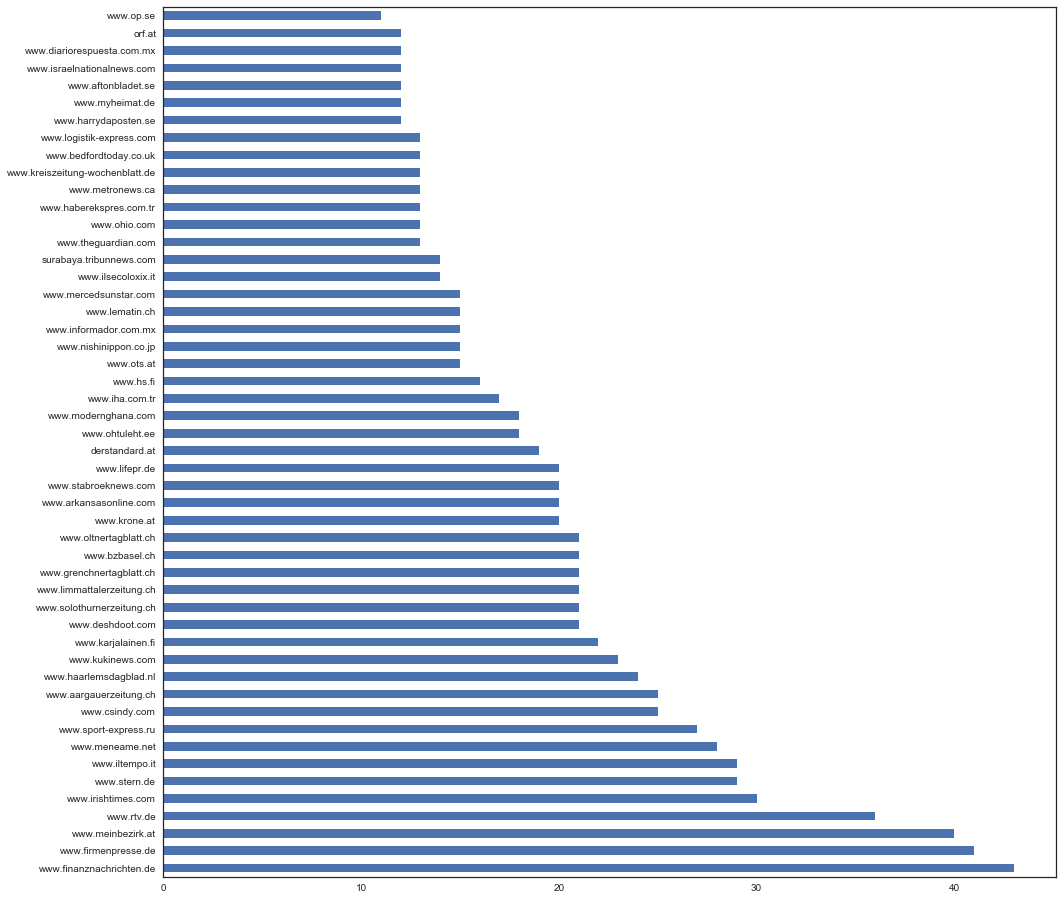

In [90]:
cleaned_data['host'] = cleaned_data['uri'].apply(lambda url: urllib.parse.urlparse(url).netloc)

cleaned_data['host'].value_counts().sort_values(ascending = False).head(50).plot(kind='barh', label='Host', figsize=(16, 16))

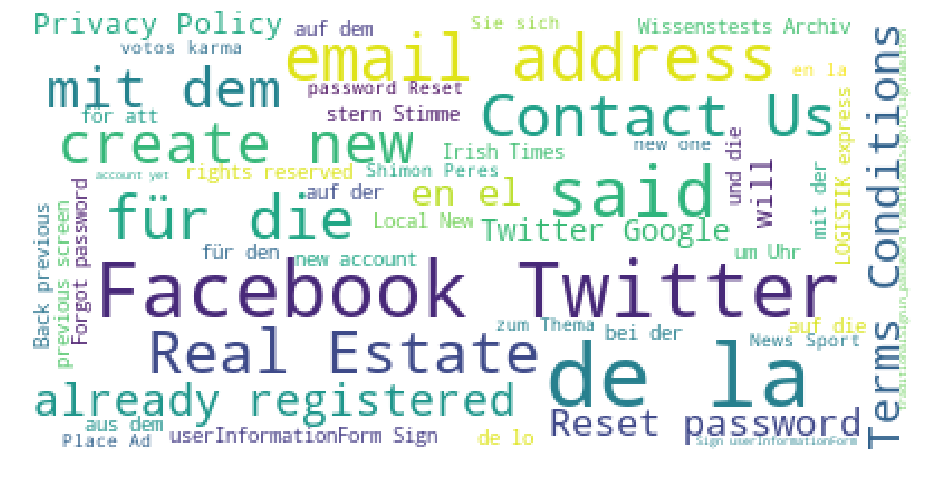

In [100]:
text = cleaned_data['text'].str.cat(sep=' ')
wordcloud = WordCloud().generate(text)
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=50,max_font_size=40, relative_scaling=.5).generate(text)
plt.figure(figsize=(16, 16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [110]:
cv = CountVectorizer(max_features=10000)
matrix = cv.fit_transform(cleaned_data['text'])
freqs = zip(cv.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
# sort from largest to smallest
for word, freq in sorted(freqs, key=lambda x: -x[1])[0:100]:
    print('{}: {}'.format(word, freq))

the: 21609
in: 18901
to: 15064
2016: 13656
de: 13134
die: 10651
und: 10382
der: 10174
of: 10107
and: 9876
on: 8049
09: 6557
la: 5867
28: 5216
for: 5087
news: 4885
en: 4696
für: 4586
mit: 4505
your: 4476
von: 4462
ja: 4219
den: 4195
das: 3999
you: 3774
10: 3742
auf: 3711
is: 3702
with: 3682
im: 3617
at: 3467
sie: 3446
zu: 3295
it: 3263
by: 3179
an: 3099
des: 3033
ist: 2989
email: 2983
that: 2884
на: 2801
27: 2756
le: 2753
sich: 2674
this: 2592
un: 2591
us: 2534
el: 2456
sport: 2427
more: 2397
was: 2388
ein: 2374
dem: 2307
se: 2279
from: 2268
september: 2266
we: 2266
facebook: 2250
es: 2199
am: 2183
eine: 2083
new: 2040
all: 2037
video: 2017
home: 2002
que: 1990
aus: 1957
nicht: 1941
di: 1928
12: 1923
are: 1915
as: 1875
business: 1840
11: 1823
be: 1813
auch: 1809
password: 1781
um: 1774
account: 1773
has: 1752
et: 1747
bei: 1717
twitter: 1690
sign: 1686
will: 1685
il: 1682
20: 1640
16: 1588
26: 1586
08: 1584
have: 1572
or: 1556
als: 1536
zum: 1528
2015: 1527
so: 1513
15: 1507
da: 1506
no

In [25]:
cleaned_data['lang_length'] = cleaned_data['text'].str.len()

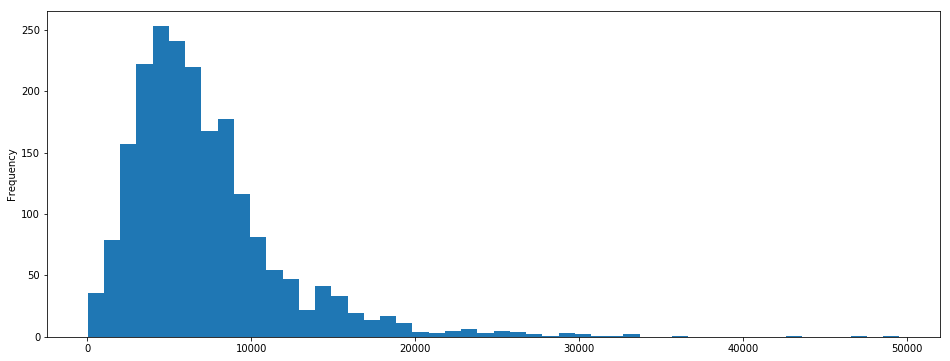

In [30]:
cleaned_data['lang_length'].plot(kind='hist', label='Text length', figsize=(16, 6), bins=50)

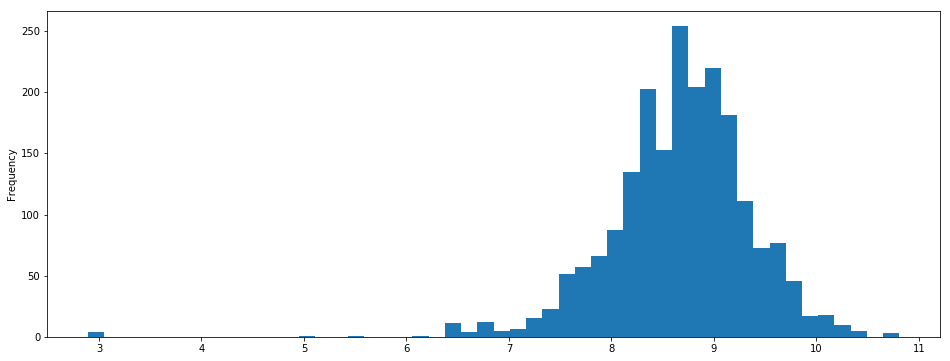

In [31]:
cleaned_data['lang_length'].apply(lambda x: math.log(x)).plot(kind='hist', label='log(Text length)', figsize=(16, 6), bins=50)

In [46]:
cleaned_data['lang_length'].describe()

count     2054.000000
mean      7168.597858
std       4883.128273
min         18.000000
25%       4034.250000
50%       6064.000000
75%       8874.500000
max      49520.000000
Name: lang_length, dtype: float64

In [18]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "N/A"
cleaned_data['lang'] = cleaned_data['text'].apply(detect_lang)

In [52]:
lang_data = pd.concat([cleaned_data['lang'], cleaned_data['lang_length']], axis=1)

In [74]:
lang_data.groupby('lang')['lang'].size().nlargest(50)

lang
de       701
en       496
es        95
ru        81
sv        66
it        64
fi        57
fr        51
tr        40
uk        35
ja        31
ro        30
nl        29
hr        27
et        26
ko        26
id        26
pl        22
mr        22
N/A       20
ar        14
ta        13
no        13
sq        11
zh-cn     10
bg         9
ml         8
mk         7
sl         7
hi         6
el         5
sk         5
pt         4
gu         3
cs         3
th         2
af         2
he         2
lv         2
da         2
ca         1
Name: lang, dtype: int64

In [76]:
lang_data.groupby('lang').describe()

lang_length                                                         \
            count          mean          std      min       25%      50%   
lang                                                                       
N/A           0.0           NaN          NaN      NaN       NaN      NaN   
af            2.0   4238.000000    19.798990   4224.0   4231.00   4238.0   
ar           14.0   6280.571429  5070.377724    958.0   4611.00   5402.5   
bg            9.0   8769.333333  4318.361321   5425.0   5540.00   5681.0   
ca            1.0   6413.000000          NaN   6413.0   6413.00   6413.0   
cs            3.0   9295.333333  2587.109648   7248.0   7841.50   8435.0   
da            2.0   7209.000000  4764.485492   3840.0   5524.50   7209.0   
de          701.0   6259.255350  4527.809708    466.0   3468.00   5470.0   
el            5.0   5064.400000  2035.980427   2081.0   4528.00   4837.0   
en          496.0   7847.745968  4075.351765     18.0   5162.50   7733.0   
es           95.0   5799.105263  4213.910585   2138.0   3505.50   4722.0   
et           26.0  18246.576923  4160.926168   7758.0  16642.75  17934.0   
fi           57.0  17560.263158  8598.236089   2193.0  13644.00  14753.0   
fr           51.0  10041.666667  4580.397833   2013.0   7857.50   9954.0   
gu            3.0   5555.666667  1457.279772   4424.0   4733.50   5043.0   
he            2.0   4843.500000   439.113311   4533.0   4688.25   4843.5   
hi            6.0   3988.166667   629.006651   3183.0   3597.75   4012.0   
hr           27.0   4079.518519  1796.122027   1824.0   2823.50   3956.0   
id           26.0   3883.461538   581.850306   2161.0   3658.50   3915.0   
it           64.0   5732.421875  1960.833066   3294.0   4169.00   5343.5   
ja           31.0   3147.000000  1551.886443   1371.0   2104.00   2323.0   
ko           26.0   1579.500000   541.198836    881.0    916.00   1814.5   
lv            2.0  21899.000000   857.013419  21293.0  21596.00  21899.0   
mk            7.0   6581.000000   598.627319   5790.0   6093.00   6692.0   
ml            8.0   3551.875000   427.940396   2715.0   3388.75   3563.5   
mr           22.0   6346.681818  1997.242251   2244.0   5742.00   6159.5   
nl           29.0   5777.068966   842.925896   3493.0   5794.00   5946.0   
no           13.0   6757.153846  2885.022266   2018.0   5549.00   7026.0   
pl           22.0   9709.000000  4337.065730   2232.0   7137.25   9361.0   
pt            4.0   3237.250000  2363.120589    713.0   1484.00   3407.5   
ro           30.0   5424.300000  3760.882656   1750.0   2058.75   5602.5   
ru           81.0   7638.864198  3364.856185   3415.0   5868.00   7158.0   
sk            5.0  12179.400000  2140.869987   9981.0  10633.00  11490.0   
sl            7.0   5460.571429  1247.701735   4207.0   4630.50   4724.0   
sq           11.0  10284.909091  5743.916076   4147.0   8228.50   8569.0   
sv           66.0   7399.560606  2400.603912   2772.0   5889.00   7342.0   
ta           13.0   4162.000000  3144.319428   1849.0   2981.00   3424.0   
th            2.0   5318.500000  3338.251114   2958.0   4138.25   5318.5   
tr           40.0   8339.125000  3893.345988   1661.0   5859.25   6688.5   
uk           35.0   5847.085714  3236.826109   2482.0   3688.50   5061.0   
zh-cn        10.0   6453.700000  2494.829277   2147.0   4629.25   7226.0   

                          
            75%      max  
lang                      
N/A         NaN      NaN  
af      4245.00   4252.0  
ar      6535.75  21042.0  
bg     11078.00  17510.0  
ca      6413.00   6413.0  
cs     10319.00  12203.0  
da      8893.50  10578.0  
de      7691.00  47012.0  
el      6538.00   7338.0  
en      9823.75  49520.0  
es      7333.00  25516.0  
et     19104.50  25072.0  
fi     25006.00  35879.0  
fr     12398.50  21193.0  
gu      6121.50   7200.0  
he      4998.75   5154.0  
hi      4220.00   4973.0  
hr      4944.50  10170.0  
id      4243.50   5080.0  
it      6735.25  12375.0  
ja      4518.50   6494.0  
ko      1907.

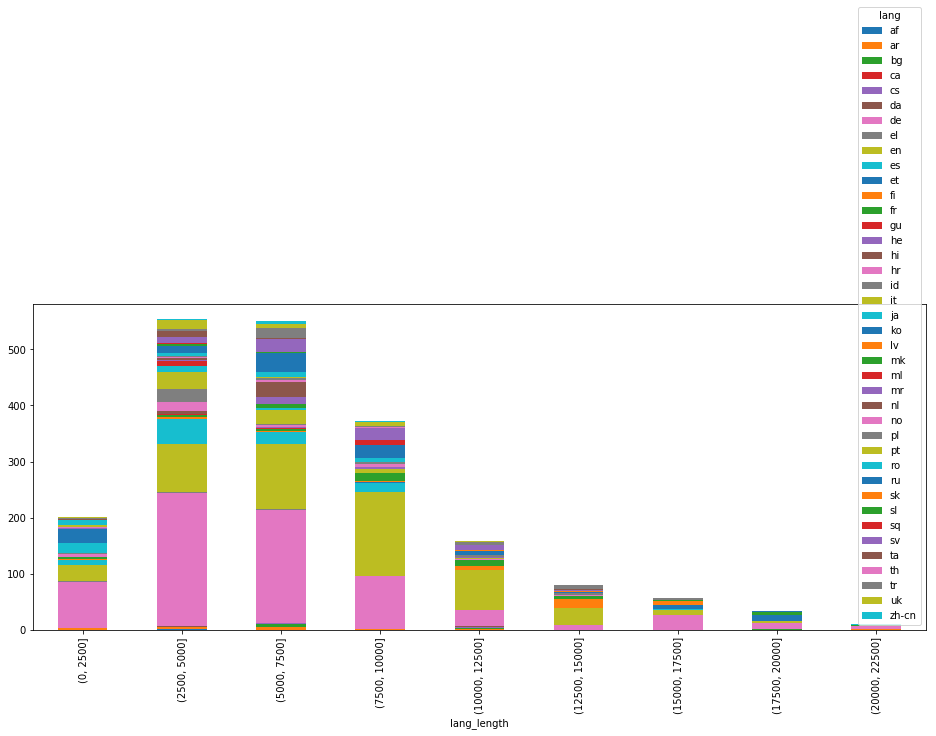

In [87]:
lang_data.groupby(['lang', pd.cut(lang_data['lang_length'], np.arange(0,25000,2500))]).size().unstack(0).plot.bar(stacked=True,  figsize=(16, 6))